In [1]:
!pip install box2d-py
!pip install gym[Box_2D]

import gym
import tensorflow as tf
import keras
from keras.models import load_model
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Activation
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque           

  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py: started
    Running setup.py install for box2d-py: finished with status 'error'


  ERROR: Complete output from command 'C:\Users\ADMIN\Anaconda3\python.exe' -u -c 'import setuptools, tokenize;__file__='"'"'C:\\Users\\ADMIN\\AppData\\Local\\Temp\\pip-install-mlan4e8z\\box2d-py\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\ADMIN\AppData\Local\Temp\pip-wheel-5tf6jr4p' --python-tag cp37:
  ERROR: Using setuptools (version 41.0.1).
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.7
  creating build\lib.win-amd64-3.7\Box2D
  copying library\Box2D\Box2D.py -> build\lib.win-amd64-3.7\Box2D
  copying library\Box2D\__init__.py -> build\lib.win-amd64-3.7\Box2D
  creating build\lib.win-amd64-3.7\Box2D\b2
  copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-3.7\Box2D\b2
  running build_ext
  building 'Box2D._Box2D' extension
  swigging Box2D\Box2D.i to Box2D\B

  Found existing installation: pyglet 1.2.4
    Uninstalling pyglet-1.2.4:
      Successfully uninstalled pyglet-1.2.4


Using TensorFlow backend.


Training DQN Agent

In [3]:
class DQN_Agent:
    def __init__(self, observation_space, action_space, lr, gamma, s_link):
        self.observation_space = observation_space  
        self.action_space = action_space  
        self.gamma = gamma
        self.lr = lr 
        self.s_link =s_link 
        self.deck = deque(maxlen=2000)
        self.epsilon = 0.7
        self.epsilon_decay= 0.995
        self.los = []
        self.ep_rewards = []

        self.model = self.MODEL()
                    
    def choose_action(self,observation):
        if np.random.rand() <= self.epsilon : 
            action = np.random.choice(len(range(4)))
            return action
            
        probs = self.model.predict(observation)    
        action = np.argmax(probs[0])
        return action
                  
    def storing(self, observation, action, reward, observation_new, flags ):
        self.deck.append((observation, action, reward, observation_new, flags ))
        self.ep_rewards.append(reward)
        
    def save(self,name):
        self.model.save(name)

    def MODEL(self):                     
        # Build Network
        model = Sequential()
        model.add(Dense(128, input_dim=self.observation_space, activation='relu'))
        model.add(Dense(128,  activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.lr))
                    
        return model
        
    def Training(self, batch):
        sample_indx = random.sample(self.deck, batch)
        self.los = []
        
        for observation, act, reward, obs_new, done in sample_indx:            
            target = reward
            if not done: 
                target = ( (1.0-0.1)*reward + 0.1 * (self.gamma*np.amax(self.model.predict(obs_new)[0])))                
            
            target_old = self.model.predict(observation)
            target_old[0][act] = target
            # Train
            history = self.model.fit(x=observation, y=target_old,\
                                #batch_size=1,\
                                verbose=0,\
                                epochs=1)
            self.los.append(history.history['loss'])    
            
            self.ep_rewards, self.ep_action = [], []
        
        mm = np.mean(self.los)                
        if self.epsilon >= 0.01:
            self.epsilon *= self.epsilon_decay
        return history, mm

Testing

In [4]:
if __name__ == '__main__':

    s_link = "lunar-lander_solved.h5"
    
    Episodes = 7000
    batch_size = 32
    lr = 0.01
    gamma = 0.995
    
    env = gym.make('LunarLander-v2')
    env = env.unwrapped
    
    agent = DQN_Agent(env.observation_space.shape[0],env.action_space.n, lr, gamma, s_link)
    
    rewards_over_time = []
    error = []
    epsilon = []
    mean_100 = []
    w = 0
        
    # Start running the episodes        
    for i in range(Episodes): 
        observation = env.reset()         
        observation = observation.reshape(1,-1)                
        
        while True:
          #env.render()
          action = agent.choose_action(observation)
          observation_new, reward, flag, inf = env.step(action)
          observation_new = observation_new.reshape(1,-1)                    
          
          agent.storing(observation, action, reward, observation_new, flag)   
          observation = observation_new         

          # Sum the episode rewards
          ep_rew_total = sum(agent.ep_rewards)
          if ep_rew_total < -300:
            flag = True
            
          if flag==True:
            rewards_over_time.append(ep_rew_total)
            max_reward = np.max(rewards_over_time)
            episode_max = np.argmax(rewards_over_time)
            if ep_rew_total >=200 :
              w = w + 1
              agent.save(s_link)
                            
            print("Episode: ", i, "Reward :", ep_rew_total)
            print("Maximum Reward: " + str(max_reward) + "  on Episode: " + str(episode_max))
            print("Times win: " + str(w))
                
            if i % 100 ==0:
                print("Mean reward of the past 100 episodes: ", str(np.mean(rewards_over_time[-100:])))
                mean_100.append(np.mean(rewards_over_time[-100:]))
                
            # Start training the Neural Network
            hist, mm= agent.Training(batch_size)
                
            epsilon.append(agent.epsilon)                                           
            error.append(mm)               
            break

C:\Users\ADMIN\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))








Episode:  0 Reward : -275.3480036161041
Maximum Reward: -275.3480036161041  on Episode: 0
Times win: 0
Mean reward of the past 100 episodes:  -275.3480036161041
Episode:  1 Reward : -300.06902376668364
Maximum Reward: -275.3480036161041  on Episode: 0
Times win: 0
Episode:  2 Reward : -386.7473302440505
Maximum Reward: -275.3480036161041  on Episode: 0
Times win: 0
Episode:  3 Reward : -277.56017155597044
Maximum Reward: -275.3480036161041  on Episode: 0
Times win: 0
Episode:  4 Reward : -139.9703320700665
Maximum Reward: -139.9703320700665  on Episode: 4
Times win: 0
Episode:  5 Reward : -225.5744882546794
Maximum Reward: -139.9703320700665  on Episode: 4
Times win: 0
Episode:  6 Reward : -222.95066250775596
Maximum Reward: -139.9703320700665  on Episode: 4
Times win: 0
Episode:  7 Reward : -36.33281550259342
Maximum Reward: -36.33281550259342  on Episode: 7
Times win: 0
Episode:  8 Reward : -337.60797055695434
Maximum Reward: -36.33281550259342  on Episode: 7
Times win: 0
Episo

Episode:  67 Reward : -259.01961958780896
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  68 Reward : -199.12531874753768
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  69 Reward : -183.22590440095436
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  70 Reward : -343.36596429240154
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  71 Reward : -185.19691051495465
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  72 Reward : -304.5021960811513
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  73 Reward : -338.8135435233946
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  74 Reward : -158.84571452842104
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  75 Reward : -102.77043694786668
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  76 Reward : -246.85914038966246
Maximu

Episode:  145 Reward : -303.4832965229349
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  146 Reward : -104.4946048629699
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  147 Reward : -155.776937452172
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  148 Reward : -301.082228407245
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  149 Reward : -304.41013659989676
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  150 Reward : -337.62015878904015
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  151 Reward : -395.89651456747356
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  152 Reward : -300.48670145066603
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  153 Reward : -305.1718737032417
Maximum Reward: -30.70283399782612  on Episode: 45
Times win: 0
Episode:  154 Reward : -395.9291043997905
Ma

Episode:  222 Reward : -300.7843357455159
Maximum Reward: 2.5719289767022673  on Episode: 202
Times win: 0
Episode:  223 Reward : -300.4401805109496
Maximum Reward: 2.5719289767022673  on Episode: 202
Times win: 0
Episode:  224 Reward : -301.94750016212686
Maximum Reward: 2.5719289767022673  on Episode: 202
Times win: 0
Episode:  225 Reward : -300.7853973727493
Maximum Reward: 2.5719289767022673  on Episode: 202
Times win: 0
Episode:  226 Reward : -302.7306396475349
Maximum Reward: 2.5719289767022673  on Episode: 202
Times win: 0
Episode:  227 Reward : -301.78241088736166
Maximum Reward: 2.5719289767022673  on Episode: 202
Times win: 0
Episode:  228 Reward : -243.76189084029457
Maximum Reward: 2.5719289767022673  on Episode: 202
Times win: 0
Episode:  229 Reward : -308.15360803174065
Maximum Reward: 2.5719289767022673  on Episode: 202
Times win: 0
Episode:  230 Reward : -348.85436911014733
Maximum Reward: 2.5719289767022673  on Episode: 202
Times win: 0
Episode:  231 Reward : -284.3871

Episode:  300 Reward : -150.27167932446918
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Mean reward of the past 100 episodes:  -247.47073238630128
Episode:  301 Reward : -206.2800178175145
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  302 Reward : -64.13508712934238
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  303 Reward : -195.21275563735395
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  304 Reward : -197.99488613271353
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  305 Reward : -300.7143838342385
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  306 Reward : -288.63720099248053
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  307 Reward : -344.11390746911053
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  308 Reward : -234.51298399943664
Maximum Reward: 110.71127255742755  o

Episode:  377 Reward : -203.091630640741
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  378 Reward : -309.07488204823795
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  379 Reward : -307.0264321082164
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  380 Reward : -308.726299077278
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  381 Reward : -302.1717964089859
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  382 Reward : -308.0785762913409
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  383 Reward : -304.6688577899326
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  384 Reward : -302.324364685721
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  385 Reward : -302.83439015022674
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  386 Reward : -301.1226387993

Episode:  453 Reward : -115.2367261001074
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  454 Reward : -256.9899116915889
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  455 Reward : -254.38023391299816
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  456 Reward : -93.9421623895404
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  457 Reward : -150.78086868590754
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  458 Reward : -186.472625547277
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  459 Reward : -185.3311649080078
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  460 Reward : -174.0629753800419
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  461 Reward : -79.304655528344
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  462 Reward : -153.16569972633

Episode:  530 Reward : -146.68865149112744
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  531 Reward : -149.35069866366533
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  532 Reward : -104.08972602279951
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  533 Reward : -117.34353134715757
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  534 Reward : -193.65169065979785
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  535 Reward : -161.65149340183746
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  536 Reward : -142.68024782526146
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  537 Reward : -112.38124714507987
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  538 Reward : -83.65126588908254
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  539 Reward : -110.7

Episode:  606 Reward : -148.91696733916976
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  607 Reward : -155.3712424464421
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  608 Reward : -135.64048063529745
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  609 Reward : -172.69771522646258
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  610 Reward : -152.09195030869628
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  611 Reward : -99.58685459636712
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  612 Reward : -128.7761449992214
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  613 Reward : -119.36230382061969
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  614 Reward : -268.4606104259321
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  615 Reward : -124.0165

Episode:  683 Reward : -102.71707787089017
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  684 Reward : -120.19664236945698
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  685 Reward : -143.15262804894758
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  686 Reward : -9.955717415090177
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  687 Reward : -88.13059703452372
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  688 Reward : -118.8754228280522
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  689 Reward : -97.70080600305371
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  690 Reward : -78.66794637044713
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  691 Reward : -126.99932783472744
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  692 Reward : -122.78025

Episode:  759 Reward : -117.71486750781982
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  760 Reward : -116.50760129530337
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  761 Reward : -144.98549262746565
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  762 Reward : -78.71065868391959
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  763 Reward : -137.4755142248113
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  764 Reward : -144.4104320065173
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  765 Reward : -91.63266086109837
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  766 Reward : -186.1394167251787
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  767 Reward : -151.47820911663155
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  768 Reward : -132.32283

Episode:  835 Reward : -119.85717046723849
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  836 Reward : -104.12154637857674
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  837 Reward : -155.59238291359475
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  838 Reward : -135.10062910200364
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  839 Reward : -135.68309450581867
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  840 Reward : -130.80321587057668
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  841 Reward : -177.75429217150452
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  842 Reward : -141.63015358295502
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  843 Reward : -126.3259255599009
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  844 Reward : -103.8

Episode:  912 Reward : -337.19093023275815
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  913 Reward : -339.71599615435656
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  914 Reward : -390.5353251495945
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  915 Reward : -219.23189090147727
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  916 Reward : -326.62177892406754
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  917 Reward : -346.7993599672536
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  918 Reward : -335.6224926361598
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  919 Reward : -297.316178717218
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  920 Reward : -241.58613427947347
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  921 Reward : -249.35875

Episode:  989 Reward : -388.1951656098297
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  990 Reward : -306.60447625504855
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  991 Reward : -76.78714723024554
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  992 Reward : -47.229451219173654
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  993 Reward : -158.31841285410118
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  994 Reward : -344.0040960289859
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  995 Reward : -329.26214626049295
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  996 Reward : -208.2766229584609
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  997 Reward : -306.4803589982597
Maximum Reward: 110.71127255742755  on Episode: 295
Times win: 0
Episode:  998 Reward : -308.17862

Episode:  1065 Reward : -238.35018193899026
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1066 Reward : -184.92035197058476
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1067 Reward : -305.07676385370667
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1068 Reward : -300.91333266911255
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1069 Reward : -288.95435733353116
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1070 Reward : -309.2984833834412
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1071 Reward : -225.2902952953234
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1072 Reward : -385.97694227577745
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1073 Reward : -307.6294224163725
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1074 Reward 

Episode:  1140 Reward : -139.19693563146467
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1141 Reward : -135.75434492758578
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1142 Reward : -177.89219626340412
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1143 Reward : -110.83411337264039
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1144 Reward : -132.72002842156272
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1145 Reward : -164.6651062573133
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1146 Reward : -22.730119784115345
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1147 Reward : -146.3423230348924
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1148 Reward : -162.29106641308613
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1149 Reward

Episode:  1216 Reward : -136.99315194028344
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1217 Reward : -160.21843444719198
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1218 Reward : -104.82961306525655
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1219 Reward : -154.5730362192055
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1220 Reward : 9.31467142762807
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1221 Reward : -130.8233973877939
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1222 Reward : -120.36455472345591
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1223 Reward : -169.6649603774254
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1224 Reward : -108.19339037848195
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1225 Reward : -

Episode:  1292 Reward : -121.82105097959479
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1293 Reward : -101.93282029429298
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1294 Reward : -141.72178512262462
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1295 Reward : -89.73748952035302
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1296 Reward : -137.4069815787776
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1297 Reward : -120.58275262046487
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1298 Reward : -115.1779316218574
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1299 Reward : -103.55374684532151
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1300 Reward : -130.55246532632756
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Mean reward of the pas

Episode:  1368 Reward : -196.03153270248208
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1369 Reward : -142.1463106661163
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1370 Reward : -122.47810554425055
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1371 Reward : -128.66522976935903
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1372 Reward : -122.40967107441264
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1373 Reward : -131.44325367358687
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1374 Reward : -177.3352176784861
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1375 Reward : 0.8497628262092576
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1376 Reward : -148.65123221858073
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1377 Reward 

Episode:  1444 Reward : -164.01647814638386
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1445 Reward : -143.06842396087737
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1446 Reward : -171.46983753827698
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1447 Reward : -26.47681900635733
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1448 Reward : -102.77827730415586
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1449 Reward : -141.18956644158908
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1450 Reward : -151.80938041826147
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1451 Reward : -158.20958294709757
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1452 Reward : -96.2693246416166
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1453 Reward 

Episode:  1519 Reward : -295.53968724163906
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1520 Reward : -266.55297335998455
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1521 Reward : -325.72410939125825
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1522 Reward : -187.85853371497137
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1523 Reward : -240.37260886402842
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1524 Reward : -300.66858820464125
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1525 Reward : -312.8245297595746
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1526 Reward : -192.876900834762
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1527 Reward : -218.06582890266804
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1528 Reward 

Episode:  1595 Reward : -12.254264100315723
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1596 Reward : -238.93502889759623
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1597 Reward : -126.75705441365902
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1598 Reward : -160.23673944074125
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1599 Reward : -160.6823032774326
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1600 Reward : -129.5973676072748
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Mean reward of the past 100 episodes:  -182.98928984609805
Episode:  1601 Reward : -259.8105773147058
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1602 Reward : -31.91163260935886
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1603 Reward : -187.27285969063692
Maximum Reward: 229.269359791

Episode:  1670 Reward : 178.64553759128052
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1671 Reward : -66.8228862590142
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1672 Reward : -191.41920194518445
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1673 Reward : -252.0007879903496
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1674 Reward : -287.38243996178846
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1675 Reward : -307.36914638643674
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1676 Reward : -303.93079063443327
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1677 Reward : -209.210497332508
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1678 Reward : -217.48043245139834
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1679 Reward : -

Episode:  1747 Reward : -153.7700885601384
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1748 Reward : -40.687184419585805
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1749 Reward : -193.67778727029167
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1750 Reward : -167.02854482002638
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1751 Reward : -196.8362388048117
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1752 Reward : -138.37982051915245
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1753 Reward : -129.52131384779125
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1754 Reward : -160.43708292190513
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1755 Reward : -142.96990004217645
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1756 Reward

Episode:  1823 Reward : -118.59443089263542
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1824 Reward : -144.605485189259
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1825 Reward : -99.12154714653224
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1826 Reward : -136.91132935244352
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1827 Reward : -135.72526738437963
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1828 Reward : -121.73118273754262
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1829 Reward : -149.38789762328906
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1830 Reward : 33.73208229535783
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1831 Reward : -126.31192878706814
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1832 Reward : 

Episode:  1900 Reward : -156.77464956684878
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Mean reward of the past 100 episodes:  -139.92985960128462
Episode:  1901 Reward : -152.14039338691845
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1902 Reward : -154.3428707545795
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1903 Reward : -135.73099228147154
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1904 Reward : -166.93537782539272
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1905 Reward : -98.38324871473739
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1906 Reward : -163.9817335334664
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1907 Reward : -189.15636904912122
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1908 Reward : -131.92125749235478
Maximum Reward: 229.26935979

Episode:  1976 Reward : -111.43533772162937
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1977 Reward : -156.56541032034278
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1978 Reward : -205.1300034993182
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1979 Reward : -152.40945677257616
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1980 Reward : -163.582659735797
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1981 Reward : -170.66365683858913
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1982 Reward : -97.1132985268444
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1983 Reward : -142.4181756522769
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1984 Reward : -145.14077395207374
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  1985 Reward : -

Episode:  2052 Reward : -168.92656894578747
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2053 Reward : -88.43526978309396
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2054 Reward : -151.29655810975999
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2055 Reward : -141.85116701227827
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2056 Reward : -137.1817931642774
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2057 Reward : -111.77639884720418
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2058 Reward : -137.65894171352198
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2059 Reward : -116.91574375825729
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2060 Reward : -149.95451160861364
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2061 Reward

Episode:  2128 Reward : -159.1563248832053
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2129 Reward : -127.25790602512166
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2130 Reward : -135.19614010174152
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2131 Reward : -110.4572392350461
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2132 Reward : -116.05910946846834
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2133 Reward : -145.46194983681002
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2134 Reward : -172.1516298286562
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2135 Reward : -140.62500461833838
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2136 Reward : -144.5178049724761
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2137 Reward :

Episode:  2204 Reward : -121.71615157572859
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2205 Reward : -146.52002809574162
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2206 Reward : -104.9230679065727
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2207 Reward : -145.5645030234937
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2208 Reward : -175.0512107684014
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2209 Reward : -123.74541983037733
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2210 Reward : -127.95403048180567
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2211 Reward : -166.4289944343307
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2212 Reward : -211.19817367972547
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2213 Reward :

Episode:  2280 Reward : -149.7894292696473
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2281 Reward : -114.95848810149539
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2282 Reward : -145.98376188540925
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2283 Reward : -176.12920341772755
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2284 Reward : -161.70011885166372
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2285 Reward : -110.54116807793801
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2286 Reward : -147.42809568309625
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2287 Reward : -106.5672758420913
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2288 Reward : -146.87866724635634
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2289 Reward

Episode:  2355 Reward : -116.18549758445937
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2356 Reward : -175.44983635683704
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2357 Reward : -115.34181250292337
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2358 Reward : -118.16626417784657
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2359 Reward : -163.82427858953557
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2360 Reward : -158.0337090199623
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2361 Reward : -156.03395584239996
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2362 Reward : -150.16464564819475
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2363 Reward : -174.36574541713668
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2364 Rewar

Episode:  2431 Reward : -203.94977877950524
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2432 Reward : -187.2328585304749
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2433 Reward : -171.45915757339304
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2434 Reward : -188.8204817493089
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2435 Reward : -140.4093942027455
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2436 Reward : -134.82194786231037
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2437 Reward : -126.05768688333032
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2438 Reward : -107.52817429107759
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2439 Reward : -190.49504585706012
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2440 Reward 

Episode:  2507 Reward : -86.14769706976129
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2508 Reward : -140.04596639762127
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2509 Reward : -101.7953558790546
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2510 Reward : -145.24798146346103
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2511 Reward : -122.10722760909394
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2512 Reward : -117.28379009103054
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2513 Reward : -123.28216322542495
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2514 Reward : -116.45234525014068
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2515 Reward : -127.88188982743844
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2516 Reward

Episode:  2583 Reward : -146.7101738465642
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2584 Reward : -155.20797324686464
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2585 Reward : -136.11961310871868
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2586 Reward : -131.75481423205233
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2587 Reward : -140.65933803453004
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2588 Reward : -123.37323244628973
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2589 Reward : -145.43412953557845
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2590 Reward : -128.8959889996207
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2591 Reward : -147.81228037013193
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2592 Reward

Episode:  2659 Reward : -147.01890897279193
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2660 Reward : -120.53170736479292
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2661 Reward : -111.80072221781752
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2662 Reward : -131.858349170055
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2663 Reward : -124.24752133532165
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2664 Reward : -160.79838476844378
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2665 Reward : -166.81929627951547
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2666 Reward : -26.89319789189686
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2667 Reward : -92.25737311272239
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2668 Reward :

Episode:  2734 Reward : -203.72365001718086
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2735 Reward : -148.26548317553278
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2736 Reward : -102.71658490440535
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2737 Reward : -141.8126620129571
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2738 Reward : -124.66480978266335
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2739 Reward : -130.2134179486254
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2740 Reward : -123.99718509808449
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2741 Reward : -159.3287458301291
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2742 Reward : 5.942526834798215
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2743 Reward : 

Episode:  2810 Reward : -139.56235749253767
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2811 Reward : -148.16231319163822
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2812 Reward : -111.84499878091509
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2813 Reward : -125.26495457162908
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2814 Reward : -129.6496419208716
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2815 Reward : -112.440277686803
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2816 Reward : -101.8683997739123
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2817 Reward : -136.08562957925037
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2818 Reward : -138.18965711238155
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2819 Reward :

Episode:  2886 Reward : -224.28511046690804
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2887 Reward : -83.40214180551936
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2888 Reward : -135.4150897257498
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2889 Reward : -197.7701341158278
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2890 Reward : -302.8474171057395
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2891 Reward : -149.17813110802382
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2892 Reward : -197.18728819313773
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2893 Reward : -90.59192326240745
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2894 Reward : -68.23360370943412
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2895 Reward : -

Episode:  2962 Reward : -303.3022003336375
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2963 Reward : -306.5021752746355
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2964 Reward : -302.5576916392968
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2965 Reward : -158.89372423920184
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2966 Reward : -145.73106286332745
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2967 Reward : -296.5986824196494
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2968 Reward : -279.88129279497787
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2969 Reward : -176.24733989100628
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2970 Reward : -206.5405949477995
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  2971 Reward : 

Episode:  3037 Reward : -162.64516178161279
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  3038 Reward : -180.80660147988178
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  3039 Reward : -172.85941470699555
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  3040 Reward : -161.93495304280435
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  3041 Reward : -318.2720684813865
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  3042 Reward : -213.18676583514056
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  3043 Reward : -241.3639309329061
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  3044 Reward : -193.05468266029163
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  3045 Reward : -301.4872908044899
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 1
Episode:  3046 Reward 

Episode:  3112 Reward : -151.30874610346865
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3113 Reward : -192.90131335825842
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3114 Reward : -224.5108786011238
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3115 Reward : -238.54821537446458
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3116 Reward : -246.16335999619872
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3117 Reward : -157.4480740939929
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3118 Reward : -208.9771875173062
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3119 Reward : -356.5830010684897
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3120 Reward : -180.94265287071693
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3121 Reward :

Episode:  3188 Reward : -86.51748091137554
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3189 Reward : -30.94407432411846
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3190 Reward : -297.729058507516
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3191 Reward : -244.47622165601916
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3192 Reward : -293.47783824170995
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3193 Reward : -178.51291534013637
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3194 Reward : 24.070397223947566
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3195 Reward : -182.22117420806507
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3196 Reward : -109.49154681544519
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3197 Reward : 

Episode:  3264 Reward : -215.16255678268124
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3265 Reward : -284.9851167227178
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3266 Reward : -240.70822677002877
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3267 Reward : -228.57956505161118
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3268 Reward : -353.89214640120963
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3269 Reward : -146.12634528532595
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3270 Reward : -123.34459572763078
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3271 Reward : -127.82131358153383
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3272 Reward : -30.013886837081472
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3273 Rewar

Episode:  3339 Reward : -116.37611473127072
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3340 Reward : -86.89714729009596
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3341 Reward : -99.27611927575295
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3342 Reward : -108.64491210780314
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3343 Reward : -124.3799506536129
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3344 Reward : -139.5964672688898
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3345 Reward : -43.59640996778835
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3346 Reward : -291.32370208545905
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3347 Reward : 1.160574655334841
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3348 Reward : -1

Episode:  3415 Reward : -250.83130091929263
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3416 Reward : -237.05715057343127
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3417 Reward : -354.80711337402056
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3418 Reward : -216.55225601514587
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3419 Reward : -305.5572097788885
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3420 Reward : -261.4581859831662
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3421 Reward : -271.1979086528664
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3422 Reward : -294.93203972078413
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3423 Reward : -231.4838490774764
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3424 Reward :

Episode:  3491 Reward : -275.2919419942788
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3492 Reward : -227.47507132802446
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3493 Reward : -311.38030121628583
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3494 Reward : -211.70051587379515
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3495 Reward : -389.2982351306475
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3496 Reward : -331.9375398552371
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3497 Reward : -366.9182755030899
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3498 Reward : -314.09474975467447
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3499 Reward : -361.7468453557178
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3500 Reward : 

Episode:  3567 Reward : -273.3400212343571
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3568 Reward : -296.101296720436
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3569 Reward : -285.0090732387846
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3570 Reward : -159.31494065324154
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3571 Reward : -131.2982245983367
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3572 Reward : -267.4179633027511
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3573 Reward : -271.9379125434155
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3574 Reward : -301.7462413696662
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3575 Reward : -307.6634698864515
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3576 Reward : -302

Episode:  3643 Reward : -127.06320582464097
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3644 Reward : -93.09461743608874
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3645 Reward : -103.6439588437508
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3646 Reward : -188.78991643967555
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3647 Reward : -147.12894173287347
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3648 Reward : -171.17108954948583
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3649 Reward : -144.65006691158217
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3650 Reward : -164.1250708022327
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3651 Reward : -37.169341142158956
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3652 Reward 

Episode:  3719 Reward : -130.519461682707
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3720 Reward : -154.1956834128734
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3721 Reward : -145.39079556304307
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3722 Reward : -75.24415290379626
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3723 Reward : -223.295223574825
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3724 Reward : -24.564318999524232
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3725 Reward : -302.23079994310297
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3726 Reward : -154.41119432988836
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3727 Reward : -177.66190157929137
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3728 Reward : -

Episode:  3795 Reward : -106.03946023210938
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3796 Reward : -232.8001553063049
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3797 Reward : -192.51468930466888
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3798 Reward : -147.3049084694248
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3799 Reward : -146.13410886224108
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3800 Reward : -145.47432094829367
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Mean reward of the past 100 episodes:  -163.91601864719163
Episode:  3801 Reward : -112.6327633139496
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3802 Reward : -302.6458606161615
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3803 Reward : -301.3163191314486
Maximum Reward: 229.2693597918

Episode:  3871 Reward : -212.50670942038875
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3872 Reward : -373.09623138904686
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3873 Reward : -286.18934720733733
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3874 Reward : -243.83772592746845
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3875 Reward : -185.93036176499504
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3876 Reward : -214.7330076668874
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3877 Reward : -132.4997489928254
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3878 Reward : -208.37277980762366
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3879 Reward : -256.17990998956685
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3880 Reward

Episode:  3947 Reward : -343.44016616094325
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3948 Reward : -300.3084389410636
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3949 Reward : -360.4414257614009
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3950 Reward : -268.27078437493196
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3951 Reward : -218.0489966370559
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3952 Reward : -258.24952612202856
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3953 Reward : -193.45431896989652
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3954 Reward : -255.72754292708515
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3955 Reward : 1.4070543708766934
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  3956 Reward :

Episode:  4023 Reward : -300.47981115247933
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4024 Reward : -313.1358650394364
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4025 Reward : -300.6143103327888
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4026 Reward : -268.6786106927876
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4027 Reward : -279.54771752748115
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4028 Reward : -312.04490677974263
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4029 Reward : -246.11784267857632
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4030 Reward : -163.70500533074852
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4031 Reward : -36.15128806569753
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4032 Reward :

Episode:  4099 Reward : -306.12156614701206
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4100 Reward : -125.82936847236317
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Mean reward of the past 100 episodes:  -261.28720428179474
Episode:  4101 Reward : -306.8093250862241
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4102 Reward : -129.34092202290634
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4103 Reward : -98.23019003303148
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4104 Reward : -140.7086333086727
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4105 Reward : -302.218446680565
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4106 Reward : -130.28148548548268
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4107 Reward : -149.08298320649885
Maximum Reward: 229.2693597918

Episode:  4175 Reward : -94.22654271208552
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4176 Reward : -294.63109327721133
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4177 Reward : -170.41532039327748
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4178 Reward : -179.10989690505812
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4179 Reward : -153.96717660708183
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4180 Reward : -104.07484311967367
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4181 Reward : -126.22587007713892
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4182 Reward : -131.57248484765267
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4183 Reward : -281.96053525769355
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4184 Rewar

Episode:  4251 Reward : -288.5973696579346
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4252 Reward : -303.23398977007673
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4253 Reward : -302.44818978591746
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4254 Reward : -318.9631234210274
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4255 Reward : -151.75611731424993
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4256 Reward : -305.16057627312796
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4257 Reward : -305.1593466497299
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4258 Reward : -303.59725305319813
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4259 Reward : -301.83572883171473
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4260 Reward 

Episode:  4327 Reward : -132.90201582780537
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4328 Reward : -138.47622360494296
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4329 Reward : -141.51905522707432
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4330 Reward : -137.04793783534072
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4331 Reward : -306.9360847940718
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4332 Reward : -307.1025690728013
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4333 Reward : -348.8360063036976
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4334 Reward : -262.0595075691592
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4335 Reward : 19.97681804046657
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4336 Reward : -

Episode:  4403 Reward : -280.7384513038513
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4404 Reward : -303.96905663624915
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4405 Reward : -268.84122220161566
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4406 Reward : -341.5501175331317
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4407 Reward : -98.17356648486555
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4408 Reward : -178.19789620776731
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4409 Reward : -112.65794365820256
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4410 Reward : -347.27686610596794
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4411 Reward : -375.4242724766086
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4412 Reward :

Episode:  4480 Reward : -151.47510766125038
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4481 Reward : -271.03971423872565
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4482 Reward : -294.49372219824556
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4483 Reward : -352.07485795621943
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4484 Reward : -300.16001205501465
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4485 Reward : -226.98135923916402
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4486 Reward : -98.28561220302676
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4487 Reward : -158.2700946948151
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4488 Reward : -74.00735827241303
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4489 Reward 

Episode:  4556 Reward : -163.38439565874612
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4557 Reward : -166.5914245523075
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4558 Reward : -150.14082022839142
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4559 Reward : -147.0855520360712
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4560 Reward : -267.06897389372796
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4561 Reward : -159.32942849722937
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4562 Reward : -148.0048515978263
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4563 Reward : -22.589764427717014
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4564 Reward : -145.84957171583608
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4565 Reward 

Episode:  4632 Reward : -352.2239002230346
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4633 Reward : -304.38013018168704
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4634 Reward : -157.72508929532518
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4635 Reward : -115.99579913942367
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4636 Reward : -143.57782964860994
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4637 Reward : -371.54870346666
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4638 Reward : -328.8732531704958
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4639 Reward : -300.58310355823505
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4640 Reward : -268.95795268194775
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4641 Reward : 

Episode:  4708 Reward : -285.31524615969045
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4709 Reward : -371.11830625727043
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4710 Reward : -301.9116814544876
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4711 Reward : -301.8695619495452
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4712 Reward : -186.49354373389525
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4713 Reward : -207.43828074091238
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4714 Reward : -392.70072908261943
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4715 Reward : -173.32672715140382
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4716 Reward : -353.1396913128367
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4717 Reward 

Episode:  4784 Reward : -252.84915075755083
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4785 Reward : -396.3457842818426
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4786 Reward : -225.3189140139699
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4787 Reward : -303.31759375188847
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4788 Reward : -175.0354833009717
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4789 Reward : -302.3889063329949
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4790 Reward : -145.54124662034425
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4791 Reward : -243.61562365593403
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4792 Reward : -307.2771656091805
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4793 Reward : 

Episode:  4860 Reward : -308.45000639532196
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4861 Reward : -304.81348400774704
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4862 Reward : -304.00782497519737
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4863 Reward : -146.85980120085722
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4864 Reward : -305.25659970004085
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4865 Reward : -304.83251961702115
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4866 Reward : -234.02928039589796
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4867 Reward : -304.6948238060468
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4868 Reward : -217.81448465931845
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4869 Rewar

Episode:  4936 Reward : -120.38948583327276
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4937 Reward : -107.48295199828634
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4938 Reward : -136.70611041628885
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4939 Reward : -340.6880301323543
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4940 Reward : -303.54748756523685
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4941 Reward : -144.7328076875715
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4942 Reward : -360.38971956501086
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4943 Reward : -383.96017698627054
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4944 Reward : -302.80286878197444
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  4945 Reward

Episode:  5012 Reward : -132.80377173435576
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5013 Reward : -303.6715089097981
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5014 Reward : -351.89208339201633
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5015 Reward : -302.1874687274742
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5016 Reward : -304.29299862897
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5017 Reward : -302.4116706448999
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5018 Reward : -186.32770980471557
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5019 Reward : -300.93979481283225
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5020 Reward : -303.187197979675
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5021 Reward : -30

Episode:  5089 Reward : -90.4932963879476
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5090 Reward : -127.26854976903692
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5091 Reward : -108.21304017456394
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5092 Reward : -141.71467301679553
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5093 Reward : -132.02365077477066
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5094 Reward : -119.22495559868062
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5095 Reward : -141.60668613214705
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5096 Reward : -92.24566895472881
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5097 Reward : -391.1596789164446
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5098 Reward :

Episode:  5165 Reward : -119.73366250878313
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5166 Reward : -145.06900938735072
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5167 Reward : -305.27716554054143
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5168 Reward : -137.59694749356154
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5169 Reward : -353.3115664449415
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5170 Reward : -219.57251952751778
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5171 Reward : -306.0455601223794
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5172 Reward : -144.92304562742328
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5173 Reward : -333.0554772887166
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5174 Reward 

Episode:  5241 Reward : -302.9243127339075
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5242 Reward : -303.9512807858899
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5243 Reward : -368.6613577078433
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5244 Reward : -304.29460509089716
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5245 Reward : -334.17522071673466
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5246 Reward : -194.453882652662
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5247 Reward : -133.77316671944342
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5248 Reward : -68.46032437990813
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5249 Reward : -300.0194927937299
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5250 Reward : -1

Episode:  5317 Reward : -304.8859850137621
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5318 Reward : -306.8792908752636
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5319 Reward : -306.83174182617495
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5320 Reward : -302.4598158084574
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5321 Reward : -313.1553986770368
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5322 Reward : -365.9502787022981
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5323 Reward : -16.16669600497326
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5324 Reward : -294.6631350061341
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5325 Reward : -128.73353402130613
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5326 Reward : -1

Episode:  5394 Reward : -243.18748350347914
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5395 Reward : -119.07477577062507
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5396 Reward : -300.34692297291144
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5397 Reward : -295.5167995667276
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5398 Reward : -139.65819137989402
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5399 Reward : -381.0139633806812
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5400 Reward : -341.5702665519573
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Mean reward of the past 100 episodes:  -278.3323881606291
Episode:  5401 Reward : -244.89031494825005
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5402 Reward : -303.73594425691186
Maximum Reward: 229.269359791

Episode:  5470 Reward : -158.1774359030021
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5471 Reward : 19.518719682808253
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5472 Reward : -163.71827931871687
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5473 Reward : -96.38857231931235
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5474 Reward : -144.8376231184847
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5475 Reward : -215.10466605526506
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5476 Reward : -147.40058460892664
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5477 Reward : -131.78239375792782
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5478 Reward : -146.9072727220061
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5479 Reward : 

Episode:  5546 Reward : -169.13540917952793
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5547 Reward : -306.65665142144576
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5548 Reward : -130.20955477631236
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5549 Reward : -164.41913166453904
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5550 Reward : -111.76444270762725
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5551 Reward : -128.31121335846876
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5552 Reward : -220.43966154046788
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5553 Reward : -397.0083646650255
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5554 Reward : -307.6403687716813
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5555 Reward

Episode:  5622 Reward : -117.65054369607147
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5623 Reward : -270.0281941454741
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5624 Reward : -140.5028342146835
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5625 Reward : -304.0121071800726
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5626 Reward : -301.4459054565818
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5627 Reward : -305.439141347049
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5628 Reward : -303.45068327860525
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5629 Reward : -303.5856122917861
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5630 Reward : -304.11399993663946
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5631 Reward : -3

Episode:  5698 Reward : -182.60708646386297
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5699 Reward : -390.4157222040083
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5700 Reward : -305.47743100477953
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Mean reward of the past 100 episodes:  -259.55050366994305
Episode:  5701 Reward : -136.27819222045144
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5702 Reward : -394.54156430071276
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5703 Reward : -230.59583035300176
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5704 Reward : -171.8643204744518
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5705 Reward : -246.94553127230705
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5706 Reward : -302.0383904393772
Maximum Reward: 229.26935979

Episode:  5775 Reward : -395.3328944957733
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5776 Reward : -307.04123633372683
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5777 Reward : -138.8498236244242
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5778 Reward : -380.37748140182316
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5779 Reward : -292.214692976318
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5780 Reward : -148.0822755033861
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5781 Reward : -390.62106717643627
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5782 Reward : -142.73070215450625
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5783 Reward : -382.16233679542336
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5784 Reward : 

Episode:  5851 Reward : -123.21098507637748
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5852 Reward : -125.35961885312926
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5853 Reward : -173.1924936070197
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5854 Reward : -104.77950923098973
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5855 Reward : -160.08559711499058
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5856 Reward : -303.55047623486087
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5857 Reward : -303.7308664029795
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5858 Reward : -303.9842146334236
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5859 Reward : -143.79527122303588
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5860 Reward 

Episode:  5927 Reward : -119.72870341580006
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5928 Reward : -109.11818057635531
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5929 Reward : -119.93699042995397
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5930 Reward : -145.1324691186137
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5931 Reward : -198.51657182971582
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5932 Reward : -278.88803426462755
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5933 Reward : -144.1543568420615
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5934 Reward : -150.28037985671824
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5935 Reward : -249.45920218728287
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  5936 Reward

Episode:  6003 Reward : -353.7308746242162
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6004 Reward : -122.78372824462485
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6005 Reward : -232.41918906924712
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6006 Reward : -136.82100390304197
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6007 Reward : -90.45660649454905
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6008 Reward : -338.88425692692124
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6009 Reward : -364.76464086048196
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6010 Reward : -358.22520976933174
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6011 Reward : -244.42752431274798
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6012 Reward

Episode:  6079 Reward : -228.02079859365756
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6080 Reward : -149.17063446172727
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6081 Reward : -354.7595050630091
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6082 Reward : -152.46906656794886
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6083 Reward : -127.35726801268233
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6084 Reward : -107.03190562209213
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6085 Reward : -168.49691925696675
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6086 Reward : -328.0490508798773
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6087 Reward : -87.72016659496401
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6088 Reward 

Episode:  6155 Reward : -78.31228893203973
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6156 Reward : -10.41796026740002
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6157 Reward : -305.93711330046136
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6158 Reward : -118.55340707731256
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6159 Reward : -101.82542068287137
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6160 Reward : -172.25339078459035
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6161 Reward : -128.5645529659264
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6162 Reward : -303.0911142064091
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6163 Reward : -305.22566492190094
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6164 Reward :

Episode:  6231 Reward : -111.14575037180627
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6232 Reward : -387.75639633549866
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6233 Reward : -155.01470733622256
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6234 Reward : -310.3966525199697
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6235 Reward : -394.35416410643114
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6236 Reward : -300.6208859347073
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6237 Reward : -302.1313773437152
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6238 Reward : -305.6582351183331
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6239 Reward : -301.70769445701336
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6240 Reward :

Episode:  6307 Reward : -305.4978864834739
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6308 Reward : -126.15634920140965
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6309 Reward : -301.8775730654129
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6310 Reward : -103.64112119911087
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6311 Reward : -87.96073839265688
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6312 Reward : -136.0053630025995
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6313 Reward : -131.81519462011443
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6314 Reward : -303.9279200500985
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6315 Reward : -309.27484769951843
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6316 Reward : 

Episode:  6384 Reward : -303.4969082347635
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6385 Reward : -161.402972181225
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6386 Reward : -392.2121329261811
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6387 Reward : -301.11586422171325
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6388 Reward : -161.88287405485954
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6389 Reward : -204.42524356858243
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6390 Reward : -130.39845593129778
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6391 Reward : -139.5547614173039
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6392 Reward : -133.80115004480604
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6393 Reward : 

Episode:  6460 Reward : -307.1193592144164
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6461 Reward : -301.2463420216924
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6462 Reward : -91.97914344720415
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6463 Reward : -304.96229598544323
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6464 Reward : -239.04606670443567
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6465 Reward : -95.95325463235483
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6466 Reward : -302.6863676019022
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6467 Reward : -110.05666413207433
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6468 Reward : -355.03351766614486
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6469 Reward : 

Episode:  6536 Reward : -178.56396152044843
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6537 Reward : -300.94092903189636
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6538 Reward : -160.66596032851197
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6539 Reward : -179.64351217848406
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6540 Reward : -335.62547092353543
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6541 Reward : -332.2529222743515
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6542 Reward : -179.09288174908943
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6543 Reward : -135.78647088076264
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6544 Reward : -303.447666223822
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6545 Reward 

Episode:  6612 Reward : -282.12578564139017
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6613 Reward : -301.8846263750371
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6614 Reward : -305.2679960460446
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6615 Reward : -125.01260922979682
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6616 Reward : -368.4802615236253
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6617 Reward : -173.93602576302573
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6618 Reward : -85.10050819914184
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6619 Reward : -369.3828436838111
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6620 Reward : -116.15999986212802
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6621 Reward : 

Episode:  6689 Reward : -301.89251508780234
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6690 Reward : -304.6106012873953
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6691 Reward : -306.7322491029872
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6692 Reward : -349.5403332957306
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6693 Reward : -369.52521183205795
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6694 Reward : -218.40125972863177
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6695 Reward : -141.20109375528642
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6696 Reward : -301.33080344842415
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6697 Reward : -88.2460674434522
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6698 Reward : 

Episode:  6765 Reward : -158.8630822976239
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6766 Reward : -100.26453289160987
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6767 Reward : -303.0554682308436
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6768 Reward : -305.57271318655455
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6769 Reward : -138.010224186633
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6770 Reward : -173.11742480116848
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6771 Reward : -105.11934993297854
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6772 Reward : -146.2822716115485
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6773 Reward : -160.43162110921259
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6774 Reward : 

Episode:  6841 Reward : -304.05580381760427
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6842 Reward : -307.4426575933011
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6843 Reward : -167.1237749615094
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6844 Reward : -171.87765094441426
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6845 Reward : -300.4362038580977
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6846 Reward : -301.0880296784106
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6847 Reward : -175.99479524025134
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6848 Reward : -197.83226342244086
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6849 Reward : -365.24294727654603
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6850 Reward :

Episode:  6917 Reward : -157.46474277709925
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6918 Reward : -306.4703841931595
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6919 Reward : -306.46678097500507
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6920 Reward : -131.89328575702777
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6921 Reward : -149.44228504516084
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6922 Reward : -304.13575338613197
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6923 Reward : -303.29944843465466
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6924 Reward : -308.9871207108649
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6925 Reward : -254.38132553148603
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6926 Reward

Episode:  6993 Reward : -163.249024796863
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6994 Reward : -308.19068292451345
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6995 Reward : -307.43655824232445
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6996 Reward : -149.0034768207698
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6997 Reward : -139.76566023334806
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6998 Reward : -68.63591718833901
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2
Episode:  6999 Reward : -135.61429560242007
Maximum Reward: 229.2693597918215  on Episode: 1008
Times win: 2


Result

In [0]:
plt.figure(1)
plt.plot(epsilon)
plt.ylabel("Epsilon value")
plt.xlabel("Episodes")
plt.title("Epsilon decay")
plt.show()

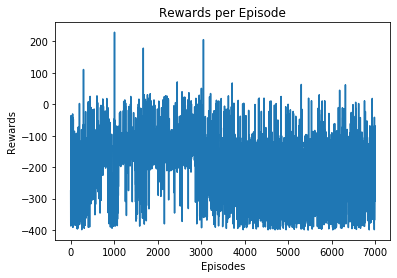

In [5]:
plt.figure(1)            
plt.plot(rewards_over_time)  
plt.ylabel("Rewards")  
plt.xlabel("Episodes")
plt.title("Rewards per Episode")
plt.show() 

In [0]:
plt.figure(1)
plt.plot(error)
plt.ylabel("Average Error")
plt.xlabel("Episodes")
plt.title("Average_Loss Vs Episodes")
plt.show()